# Forecasting Water Levels using LSTMs

In [834]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from wetterdienst.provider.dwd.observation import DwdObservationRequest, \
    DwdObservationPeriod, DwdObservationResolution, DwdObservationParameter, DwdObservationDataset

In [835]:
df = pd.read_csv('data/Kaub_Level_Since_2013.csv')
x = df[df.duplicated(['date'])].index
x

Int64Index([2521, 2535], dtype='int64')

In [836]:
df_index = df.set_index(df['date'])
df_index.index = pd.to_datetime(df_index.index)
dates_original = pd.date_range(start=df['date'].iloc[0], end=df['date'].iloc[-1]).difference(df_index.index)
print('These are the missing dates on the updated data: \n', dates_original)
print(f'There are a total of {len(dates_original)} dates missing.')

These are the missing dates on the updated data: 
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)
There are a total of 0 dates missing.


In [837]:
for element in x:
    df.drop(element, inplace=True)

In [838]:
df = df.reset_index(drop=True)

In [839]:
path = 'results/' # Path for saving the figures later on

In [840]:
def get_station_id(city):
    request = DwdObservationRequest(
        parameter=DwdObservationDataset.PRECIPITATION_MORE,
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    )
    df = request.all().df
    station_string = df[df['name'] == city].station_id
    return int(station_string.iloc[0][1:])


There is no Ludwigshafen in the DWD weather API, so I use Mannheim instead.

In [841]:
ma_id = get_station_id('Mannheim')
frei_id = get_station_id('Freiburg')

## What variables have an impact on water levels? https://ijc.org/en/lsbc/watershed/faq/3

200km: From Freiburg to Ludwigshafen. Rhine has a speed of 10 kph on average => Shift of 20h / approximately 1 day

In [842]:
def get_historical_data(station_id):
    request = DwdObservationRequest(
        parameter=[
            DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
        ],
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    ).filter_by_station_id(station_id=(station_id, ))

    return request.values.all().df

def get_recent_data(station_id):
    request = DwdObservationRequest(
        parameter=[
            DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
        ],
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.RECENT
    ).filter_by_station_id(station_id=(station_id, ))

    return request.values.all().df

In [843]:
precipitation_frei_historical = get_historical_data(frei_id)
precipitation_ma_historical = get_historical_data(ma_id)
precipitation_frei_recent = get_recent_data(frei_id)
precipitation_ma_recent= get_recent_data(ma_id)

request = DwdObservationRequest(
    parameter=[
        DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT,
        DwdObservationParameter.DAILY.PRESSURE_AIR_SITE,
        DwdObservationParameter.DAILY.TEMPERATURE_AIR_MEAN_200,
        DwdObservationParameter.DAILY.WIND_SPEED
    ],
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL
).filter_by_station_id(station_id=(5906, ))

station_data = request.values.all().df
station_data

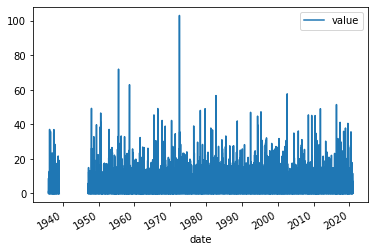

In [844]:
precipitation_ma_historical.plot(x="date", y="value")
plt.show()

There is some missing data since 1940 until 1950. This is of no concern, since I don't need this data anyway.

28125 550


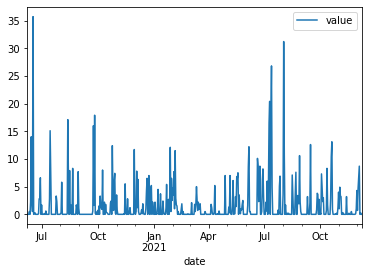

In [845]:
precipitation_ma_recent.plot(x='date', y='value')
print(len(precipitation_ma_historical), len(precipitation_ma_recent))

In [846]:
#date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d')
#timestamp_s = date_time.map(pd.Timestamp.timestamp)

Adjust the data to be in the right range:

In [847]:
precipitation_ma_historical['date'] = pd.to_datetime(precipitation_ma_historical['date'], unit='s').dt.date
precipitation_ma_recent['date'] = pd.to_datetime(precipitation_ma_recent['date'], unit='s').dt.date

In [848]:
startdate = pd.to_datetime(df['date'].iloc[0]).date()
enddate = pd.to_datetime(precipitation_ma_historical['date'].iloc[-1]).date()
precipitation_ma_historical = precipitation_ma_historical.loc[precipitation_ma_historical['date'].between(startdate, enddate, inclusive=True)]

/tmp/ipykernel_243924/1195036194.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  precipitation_ma_historical = precipitation_ma_historical.loc[precipitation_ma_historical['date'].between(startdate, enddate, inclusive=True)]


In [849]:
precipitation_ma_historical

,station_id,dataset,parameter,date,value,quality
25203,05906,climate_summary,precipitation_height,2013-01-01,0.6,9.0
25204,05906,climate_summary,precipitation_height,2013-01-02,0.0,9.0
25205,05906,climate_summary,precipitation_height,2013-01-03,1.8,9.0
25206,05906,climate_summary,precipitation_height,2013-01-04,0.3,9.0
25207,05906,climate_summary,precipitation_height,2013-01-05,0.0,9.0
...,...,...,...,...,...,...
28120,05906,climate_summary,precipitation_height,2020-12-27,4.5,3.0
28121,05906,climate_summary,precipitation_height,2020-12-28,5.2,3.0
28122,05906,climate_summary,precipitation_height,2020-12-29,0.0,3.0
28123,05906,climate_summary,precipitation_height,2020-12-30,2.2,3.0


In [850]:
startdate = pd.to_datetime("2021-1-1").date()
enddate = pd.to_datetime(df['date'].iloc[-1]).date()
precipitation_ma_recent = precipitation_ma_recent.loc[precipitation_ma_recent['date'].between(startdate, enddate, inclusive=True)]

/tmp/ipykernel_243924/992548827.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  precipitation_ma_recent = precipitation_ma_recent.loc[precipitation_ma_recent['date'].between(startdate, enddate, inclusive=True)]


In [851]:
precipitation_ma_historical[precipitation_ma_historical.isna().any(axis=1)]


,station_id,dataset,parameter,date,value,quality
27122,05906,climate_summary,precipitation_height,2018-04-04,NaN,NaN
27123,05906,climate_summary,precipitation_height,2018-04-05,NaN,NaN


In [852]:
precipitation_ma_recent[precipitation_ma_recent.isna().any(axis=1)]


,station_id,dataset,parameter,date,value,quality


Unfortunately, the the historical data of the DWD has two NaN values in it. In the following, I will simply interpolate these missing values using ffill. This will propagate the last observed value to it. This may not be the optimal solution for dealing with these two specific missing values, but in the grand scheme of things, when using an LSTM, this should not be an issue.

In [853]:
precipitation_ma_historical = precipitation_ma_historical.fillna(method='ffill')

In [854]:
precipitation_total = precipitation_ma_historical.append(precipitation_ma_recent).reset_index(drop=True)

In [855]:
precipitation_total = precipitation_total.rename({'value':'precipitation_height'}, axis=1)
precipitation_total = precipitation_total.drop(['parameter', 'dataset', 'station_id', 'quality'], axis=1)

In [856]:
print(f'Length of data: {len(df)}, length of DWD data: {len(precipitation_total)}')
assert(len(precipitation_total) == len(df))

Length of data: 3222, length of DWD data: 3222


In [857]:
df = df.drop('date', axis = 1)

In [858]:
precipitation_total = precipitation_total.drop('date', axis = 1)

In [859]:
df['precipitation_height'] = precipitation_total['precipitation_height']

## Correlation between precipitation and water level

In [860]:
df['precipitation_height'].corr(df['level'], method='pearson')

0.051382945005641625

In [861]:
df['precipitation_height'].corr(df['level'], method='spearman')

0.0872453995941518

In [862]:
df['precipitation_height'].corr(df['level'], method='kendall')

0.06425507984818286

When looking at every different correlation method, it would seem like precipitation is not correlated to the water level. An interesting thing is that spearman correlation > pearson correlation, which means that the correlation is rather monotonic than linear. Interestingly enough, it still seems that the correlation is pretty low between these two variables even though intuitively, precipitation should have a large effect on the water level. Maybe the precipitation takes longer to have an effect on the water level.

Split the data in train-validation-test split: 70:20:10 ratio. In order to get a more accurate overall presentation of the data, i.e. to guarantee that the data is i.i.d, one could randomly shuffle the data. This generally leads to lower variance and less overfitting when training a neural network. I did not decide to do this however, since this would badly influence the performance of the model because the data points are time dependent on each other.

Not shuffling the data leads to another problem: The distributions of the training/validation/test-dataset may be different. This can mean, that the model is fitting nicely on the training data, but is having trouble generalizing its "findings" onto the test dataset, since the test dataset is from another distribution. This could lead to underfitting.

In [863]:
column_indices = {name: i for i, name in enumerate(df.columns)}
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

num_features = df.shape[1]

In [864]:
train_df.describe()

,level,precipitation_height
count,2255.000000,2255.000000
mean,205.968071,1.696763
std,103.875257,4.090127
min,20.000000,0.000000
25%,137.000000,0.000000
50%,192.000000,0.000000
75%,256.000000,1.500000
max,713.000000,51.500000


In [865]:
test_df.describe()

,level,precipitation_height
count,323.000000,323.000000
mean,241.931889,1.786068
std,122.185158,3.779040
min,82.000000,0.000000
25%,152.000000,0.000000
50%,217.000000,0.000000
75%,301.500000,1.950000
max,663.000000,31.200000


In [866]:
print(f'Train mean: {train_df["level"].mean()}, Train std: {train_df["level"].std()}')

Train mean: 205.9680709534368, Train std: 103.87525729300474


In [867]:
print(f'Validation mean: {val_df["level"].mean()}, {val_df["level"].std()}')

Validation mean: 190.75776397515529, 79.95479098932333


In [868]:
print(f'Test mean: {test_df["level"].mean()}, {test_df["level"].std()}')

Test mean: 241.93188854489165, 122.18515759995832


As could be seen in the notebook 'analysis', there is a trend in the data. While there exists an overall downward trend in the water levels of the rhine, as can be seen via linear regression, the overall mean level in the last 10% of the time series actually rose significantly. This is also due to the higher standard deviation, i.e. the water levels have higher highs and lower lows.

Test, if split was successful.

In [869]:
assert(len(train_df) + len(val_df) + len(test_df) == len(df))

Maybe use moving averages instead of average in the next cell since the model shouldn't have access to future values in the training set when training?!

In [870]:
pre_transformation = train_df

Since there are many outliers, we use the RobustScaler instead of the StandardScaler.

In [871]:
scaler = RobustScaler().fit(train_df.values)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [872]:
train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
test_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

<AxesSubplot:>

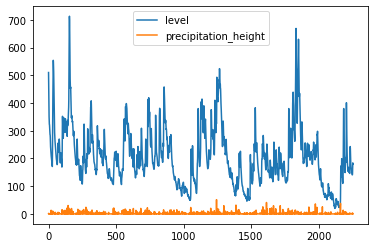

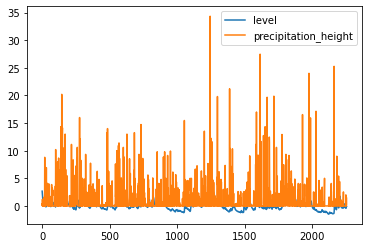

In [873]:
pre_transformation.plot()
train_df.plot()

In [874]:
print(f' The data pre transformation is in range [{pre_transformation["level"].min()},  {pre_transformation["level"].max()}]\n'
      f' the data after transformation is in range: [{round(test_df["level"].min(),2)}, {round(test_df["level"].max(), 2)}]')
      

 The data pre transformation is in range [20,  713]
 the data after transformation is in range: [-0.92, 3.96]


In [875]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [876]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [877]:
def plot(self, model=None, plot_col='level', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Day')

WindowGenerator.plot = plot


In [878]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [879]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [880]:
single_step_window = WindowGenerator(
    input_width=30, label_width=30, shift=7,
    label_columns=['level'])
single_step_window

single_step_window


Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36]
Label column name(s): ['level']

In [881]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    

Inputs shape (batch, time, features): (32, 30, 2)
Labels shape (batch, time, features): (32, 30, 1)


In [882]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [883]:
baseline = Baseline(label_index=column_indices['level'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

train_performance = {}
val_performance = {}
performance = {}
train_performance['Baseline'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


19/19 [==============================] - 0s 712us/step - loss: 0.3073 - mean_absolute_error: 0.3928


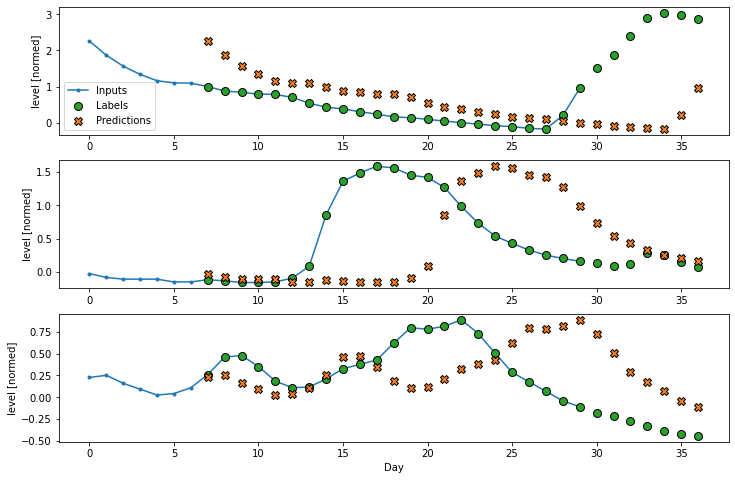

In [884]:
single_step_window.plot(baseline)


In [885]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

Using Huber Loss for more robustness against outliers (vs for example mean squared error)

In [886]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(6, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])


In [887]:
history = compile_and_fit(lstm_model, single_step_window)
IPython.display.clear_output()
train_performance['LSTM'] = lstm_model.evaluate(single_step_window.train)
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)



19/19 [==============================] - 0s 3ms/step - loss: 0.1057 - mean_absolute_error: 0.3537


In [888]:
lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 6)             216       
                                                                 
 lstm_19 (LSTM)              (None, 30, 4)             176       
                                                                 
 dense_36 (Dense)            (None, 30, 1)             5         
                                                                 
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


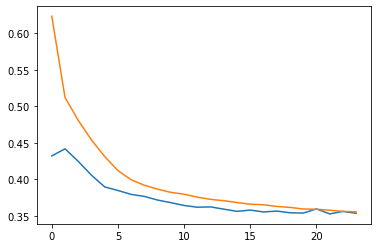

In [889]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

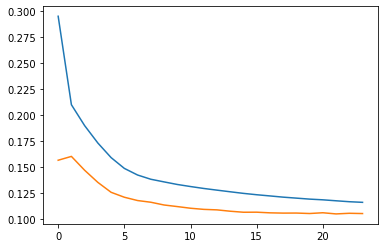

In [890]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

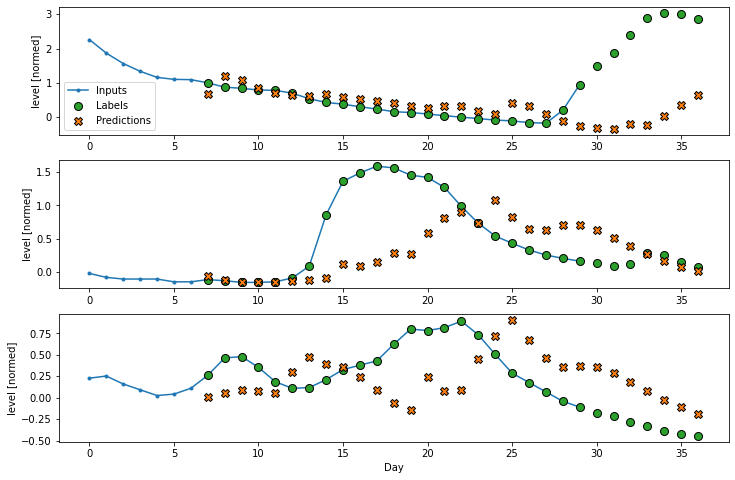

In [891]:
single_step_window.plot(lstm_model)

StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

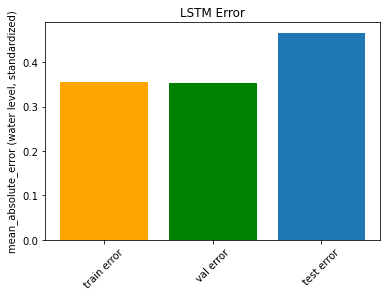

In [892]:
plt.ylabel('mean_absolute_error (water level, standardized)')
x = np.arange(3)
LSTM_performance = [train_performance['LSTM'][1], val_performance['LSTM'][1], performance['LSTM'][1]]
barlist = plt.bar(x, LSTM_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
plt.title('LSTM Error')
barlist[0].set_color('orange')
barlist[1].set_color('g')

plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
predictions = model(inputs)
plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

In [893]:
ffn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(6),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(units=1)
])


In [894]:
history = compile_and_fit(ffn_model, single_step_window)
IPython.display.clear_output()
train_performance['Dense'] = ffn_model.evaluate(single_step_window.train)
val_performance['Dense'] = ffn_model.evaluate(single_step_window.val)
performance['Dense'] = ffn_model.evaluate(single_step_window.test, verbose=0)



19/19 [==============================] - 0s 759us/step - loss: 0.1072 - mean_absolute_error: 0.3540


In [895]:
ffn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 30, 6)             18        
                                                                 
 dense_38 (Dense)            (None, 30, 4)             28        
                                                                 
 dense_39 (Dense)            (None, 30, 1)             5         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [896]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


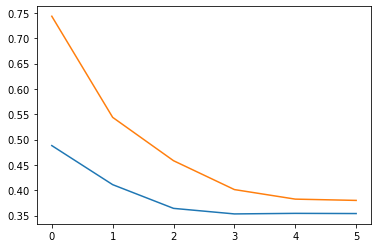

In [897]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

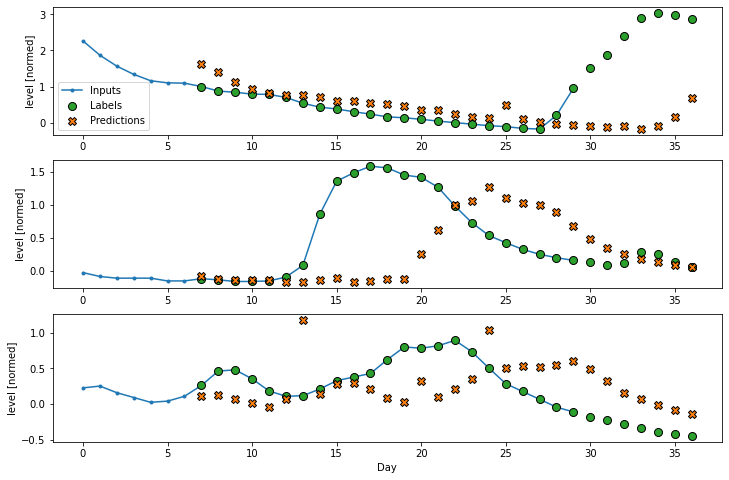

In [898]:
single_step_window.plot(ffn_model)

In [899]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name}: {value[1]:0.4f}')


Test Mean absolute Error Baseline: 0.5155
Test Mean absolute Error LSTM: 0.4660
Test Mean absolute Error Dense: 0.4453


In [900]:
print(f"LSTM: Train: {train_performance['LSTM'][1]:.2f}, Validation: {val_performance['LSTM'][1]:.2f}, Test: {performance['LSTM'][1]:.2f}")
print(f"Baseline: Train: {train_performance['Baseline'][1]:.2f}, Validation: {val_performance['Baseline'][1]:.2f}, Test: {performance['Baseline'][1]:.2f}")
print(f"Dense: Train: {train_performance['Dense'][1]:.2f}, Validation: {val_performance['Dense'][1]:.2f}, Test: {performance['Dense'][1]:.2f}")


LSTM: Train: 0.35, Validation: 0.35, Test: 0.47
Baseline: Train: 0.41, Validation: 0.39, Test: 0.52
Dense: Train: 0.38, Validation: 0.35, Test: 0.45


StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

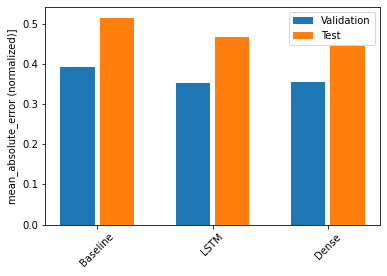

In [901]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error (normalized)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


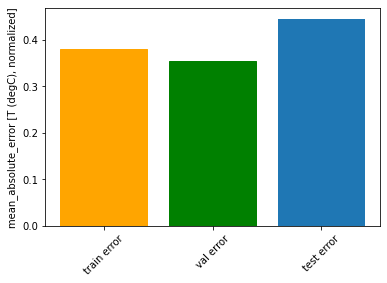

In [902]:
plt.ylabel('mean_absolute_error [T (degC), normalized]')
x = np.arange(3)
dense_performance = [train_performance['Dense'][1], val_performance['Dense'][1], performance['Dense'][1]]
barlist = plt.bar(x, dense_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')